In [139]:
from pybit.unified_trading import HTTP
import time

from get_candels import get_candels
from calculate_ta_indicators import calculate_ta_indicators
from patterns import patterns

from testing_robot import robot

from optimizer import optimization

from united_dfs import united_dfs
import matplotlib.pyplot as plt

In [140]:
from config import api_key, secret
from pybit.unified_trading import HTTP

In [141]:
import pandas as pd
import numpy as np
import math

In [142]:
import random

In [143]:
import copy


In [170]:
n = 1000
data_1h = get_candels(interval = 1, limit=n).getting_data()
indicators_1h = calculate_ta_indicators(data_1h, fastperiod=12, slowperiod=26, signalperiod=9, rsi=14)
small_period = united_dfs(data_1h, indicators_1h)


In [162]:
def gen_buy_prices(n):

    sampled_values = []
    array = list(range(len(small_period)))

    sampled_values = random.sample(array, n)
    sampled_values = list(set(sampled_values))
    sampled_values.sort()

    while (1 in np.diff(sampled_values)):
        for i in range(len(sampled_values) -1):
            if sampled_values[i+1] - sampled_values[i] == 1:
                sampled_values[i] = random.choice(list(set(array) - set(sampled_values)))
            
            sampled_values.sort()
            # print((1 in np.diff(sampled_values)), len(sampled_values) < n)

            



        
    return sampled_values


In [469]:
gen_buy_prices(2)

[256, 505]

In [495]:
def gen_sell_prices(b_p):
    s_p = []
    for i in range(len(b_p) - 1):
        prices_indexes = list(range(b_p[i]+1, b_p[i+1]))
        prices = small_period['open'].iloc[prices_indexes].values
        price_index = small_period['open'].iloc[prices_indexes].index
        b_p_index = np.argmax(prices)
        s_p.append(price_index[b_p_index])
    return s_p


In [496]:
def filter_points(individual):
    ind = individual
    buy = []
    sell = []
    for i in range(len(ind['buy'])):
        b_p = ind['buy'][i]
        s_p = ind['sell'][i]

        revenue = small_period['open'].iloc[s_p] - small_period['open'].iloc[b_p] -(small_period['open'].iloc[s_p] + small_period['open'].iloc[b_p])*0.001
        if revenue > 0:
            buy.append(b_p)
            sell.append(s_p)
    return {'buy':buy, 'sell':sell}

In [607]:
def gen_individual(n = 200):
    buy_1 = gen_buy_prices(n)
    sell_1 = gen_sell_prices(buy_1)
    buy_1 = buy_1[:-1]
    ind1 = {'buy':buy_1, 'sell':sell_1}

    f_p = filter_points(ind1)
    if f_p['buy']:
        return f_p
    else:
        return ind1 

In [590]:
def custom_crossover(ind1, ind2):
    n_min = min(len(ind1[0]['buy']), len(ind2[0]['buy']))
    n_max = max(len(ind1[0]['buy']), len(ind2[0]['buy']))

    change_number = random.randint(1, n_min)
    # print(change_number)
    
    for _ in range(change_number):
        i = random.randint(0, n_max -1)
        k = random.randint(0, n_min -1)
        # print(i, k)
        child_1 = copy.deepcopy(ind1[0])
        child_2 = copy.deepcopy(ind2[0])

        if len(ind1[0]['buy']) > len(ind2[0]['buy']):

            child_1['buy'][i] = ind2[0]['buy'][k]
            child_1['sell'][i] = ind2[0]['sell'][k]

            child_2['buy'][k] = ind1[0]['buy'][i]
            child_2['sell'][k] = ind1[0]['sell'][i]
        else:
            child_1['buy'][k] = ind2[0]['buy'][i]
            child_1['sell'][k] = ind2[0]['sell'][i]

            child_2['buy'][i] = ind1[0]['buy'][k]
            child_2['sell'][i] = ind1[0]['sell'][k]

    
    child_1['buy'].sort()
    child_1['sell'].sort()
    child_2['buy'].sort()
    child_2['sell'].sort()

    return child_1, child_2




In [592]:
def custom_mutation(ind):
    if len(ind[0]['buy']) > 1:
        change_number = random.randint(2, 10)
        for _ in range(change_number):
            i = random.randint(0, len(ind[0]['buy']) -1)
            changed_ind = copy.deepcopy(ind[0])

            if i == 0:
                changed_ind['buy'][i] = random.randint(i, changed_ind['buy'][i+1] - 1)
                changed_ind['sell'][i] = random.randint(changed_ind['sell'][i] + 1, changed_ind['sell'][i + 1] - 1)

            elif i == len(ind[0]['buy']) -1:
                changed_ind['buy'][i] = random.randint(changed_ind['buy'][i], len(small_period) - 1)
                changed_ind['sell'][i] = random.randint(changed_ind['sell'][i] + 1, len(small_period))
            
            else:
                changed_ind['buy'][i] = random.randint(changed_ind['buy'][i-1], changed_ind['buy'][i+1])
                changed_ind['sell'][i] = random.randint(changed_ind['sell'][i]+1, changed_ind['sell'][i+1]-1)

        changed_ind['buy'].sort()
        changed_ind['sell'].sort()
        
        return changed_ind
    else:

        return gen_individual(random.randint(10, 200))
        





In [593]:
def evalOneMax(individual):
    revenue = 0
    ind = individual[0]
    for i in range(len(ind['buy'])):
        b_p = ind['buy'][i]
        s_p = ind['sell'][i]

        revenue += small_period['open'].iloc[s_p] - small_period['open'].iloc[b_p] -(small_period['open'].iloc[s_p] + small_period['open'].iloc[b_p])*0.001
    return revenue,

In [594]:
def evalOneMax(individual):
    mistakes = 0
    ind = individual[0]
    for i in range(len(ind['buy'])):
        b_p = ind['buy'][i]
        s_p = ind['sell'][i]

        revenue = small_period['open'].iloc[s_p] - small_period['open'].iloc[b_p] -(small_period['open'].iloc[s_p] + small_period['open'].iloc[b_p])*0.001
        if revenue < 0:
            mistakes += 1
    if mistakes == 0:
        return 1 * len(ind['buy']),
    else:
        return 1/mistakes * len(ind['buy']),

In [595]:
from deap import base
from deap import creator
from deap import tools

In [597]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [680]:
n = 10
toolbox = base.Toolbox()
toolbox.register("i", gen_individual, n)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.i, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", custom_crossover)
toolbox.register("mutate", custom_mutation)
toolbox.register("select", tools.selTournament, tournsize=2)


In [681]:

pop = toolbox.population(n=300)
# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
    
CXPB, MUTPB = 0.5, 0.3

# Extracting all the fitnesses of 

fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
means = []
# Begin the evolution
while g < 20:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)

        # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            # print(mutant)
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    pop[:] = offspring

            # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
    means.append(mean)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
# return best_ind, best_ind.fitness.values

-- Generation 1 --
  Min 2.0
  Max 7.0
  Avg 3.9266666666666667
  Std 1.0334193512585086
-- Generation 2 --
  Min 3.0
  Max 7.0
  Avg 4.52
  Std 0.8580598269740127
-- Generation 3 --
  Min 3.0
  Max 7.0
  Avg 4.966666666666667
  Std 0.701585505994972
-- Generation 4 --
  Min 4.0
  Max 7.0
  Avg 5.233333333333333
  Std 0.6209312003399051
-- Generation 5 --
  Min 4.0
  Max 7.0
  Avg 5.493333333333333
  Std 0.6757382793820566
-- Generation 6 --
  Min 5.0
  Max 7.0
  Avg 5.79
  Std 0.7343250869562713
-- Generation 7 --
  Min 5.0
  Max 7.0
  Avg 6.156666666666666
  Std 0.7015142352242243
-- Generation 8 --
  Min 5.0
  Max 7.0
  Avg 6.53
  Std 0.5559676249567063
-- Generation 9 --
  Min 6.0
  Max 7.0
  Avg 6.8133333333333335
  Std 0.3896437118987229
-- Generation 10 --
  Min 6.0
  Max 7.0
  Avg 6.943333333333333
  Std 0.23120457511813747
-- Generation 11 --
  Min 6.0
  Max 7.0
  Avg 6.996666666666667
  Std 0.05763872155258523
-- Generation 12 --
  Min 7.0
  Max 7.0
  Avg 7.0
  Std 0.0
-- Gen

In [682]:
def filter_final_points(individual):
    ind = individual[0]
    buy = []
    sell = []
    for i in range(len(ind['buy'])):
        b_p = ind['buy'][i]
        s_p = ind['sell'][i]

        revenue = small_period['open'].iloc[s_p] - small_period['open'].iloc[b_p] -(small_period['open'].iloc[s_p] + small_period['open'].iloc[b_p])*0.001
        if revenue > 0:
            buy.append(b_p)
            sell.append(s_p)
    return {'buy':buy, 'sell':sell}

In [683]:
filtered_best_ind = filter_final_points(best_ind)

In [684]:
filtered_best_ind

{'buy': [23, 71, 343, 473, 597, 787, 811],
 'sell': [42, 208, 463, 563, 650, 797, 856]}

In [674]:
best_fit = 0 
fitnesses = []

for _ in range(1000):
    ind = gen_individual(n=200)
    fit = evalOneMax([ind])[0]
    fitnesses.append(fit)
    if fit > best_fit:
        best_fit = fit
        best_ind = ind

    

In [675]:
best_fit

13

In [677]:
best_ind

{'buy': [188, 203, 289, 439, 449, 788, 811, 843, 897, 911, 915, 931, 961],
 'sell': [194, 208, 301, 444, 461, 795, 821, 850, 901, 914, 923, 934, 963]}

In [638]:
target = []
for x in range(len(data_1h)):
    if x in best_ind['buy']:
        target.append(1)
    elif x in best_ind['sell']:
        target.append(0)
    else:
        target.append(2)
data_1h['target'] = target
indicators_1h = calculate_ta_indicators(data_1h, fastperiod=12, slowperiod=26, signalperiod=9, rsi=14)
small_period = united_dfs(data_1h, indicators_1h)

In [644]:
cols = ['volume', 'macd', 'macdsignal', 'macdhist', 'rsi', 'aroon_osc', 'target']

In [645]:
data = small_period[cols]

In [678]:
data

,volume,macd,macdsignal,macdhist,rsi,aroon_osc,target
0,1.902077,27.651637,31.724666,-4.073029,71.743724,92.857143,2
1,1.191394,26.428478,30.665429,-4.236951,71.160292,85.714286,2
2,2.229227,24.137530,29.359849,-5.222319,62.525837,71.428571,2
3,2.510053,21.890462,27.865972,-5.975510,61.153819,71.428571,2
4,4.276626,18.601728,26.013123,-7.411395,52.239913,-35.714286,2
...,...,...,...,...,...,...,...
962,8.730306,-86.947631,-47.674597,-39.273035,33.143971,-78.571429,2
963,6.824570,-89.504295,-56.040536,-33.463759,32.503809,-78.571429,2
964,5.758947,-86.725335,-62.177496,-24.547839,37.943808,-78.571429,2
965,17.762995,-74.331731,-64.608343,-9.723388,48.836785,-71.428571,2


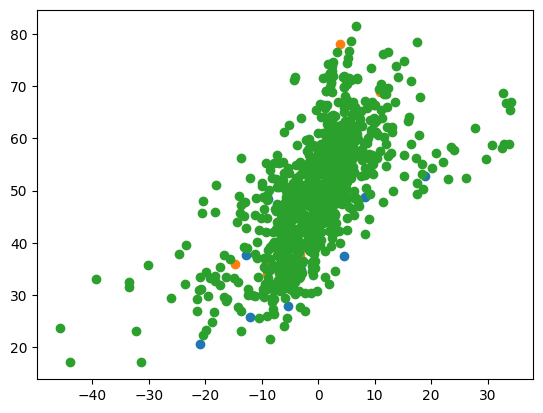

In [687]:
for i in [0,1,2]:
    X = data[data['target'] == i]['macdhist']
    y = data[data['target'] == i]['rsi']
    plt.scatter(X, y)

In [654]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [671]:
X = data[['volume','macdhist', 'rsi', 'aroon_osc']].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

In [672]:
pca_data = pd.DataFrame({'1': X_r[:,1], '2':X_r[:,0], 'target':data['target']})

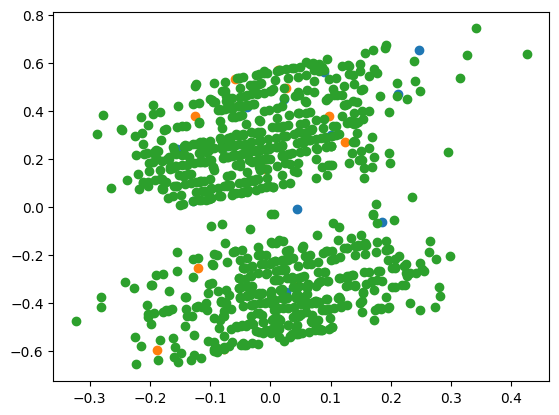

In [673]:
for i in [0,1,2]:
    X = pca_data[pca_data['target'] == i]['1']
    y = pca_data[pca_data['target'] == i]['2']
    plt.scatter(X, y)

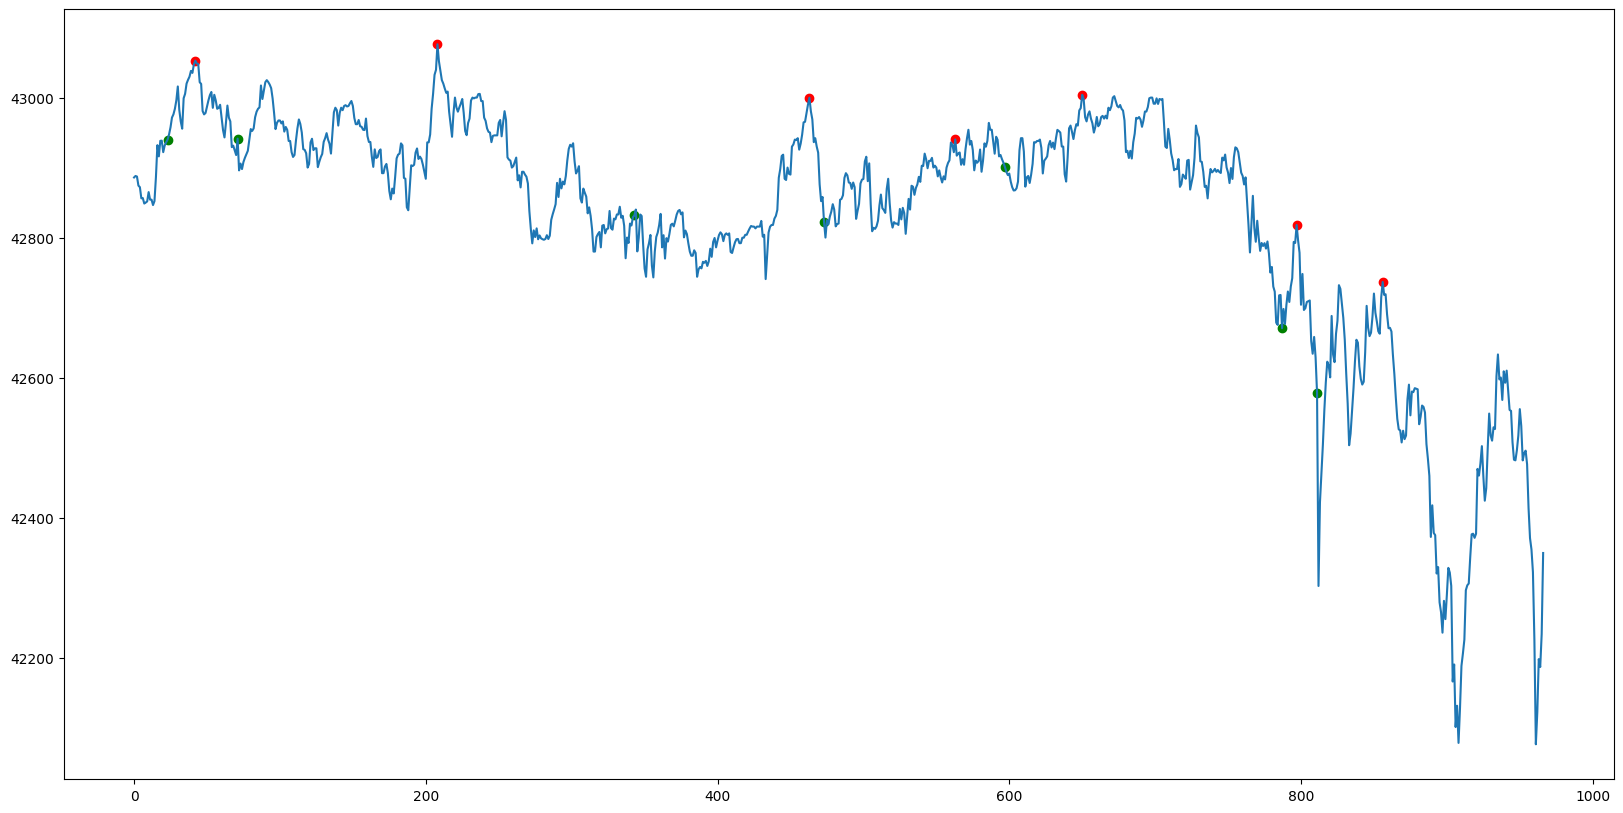

In [685]:

plt.figure(figsize=(20,10))
plt.plot(range(len(small_period['open'])),small_period['open'])
plt.scatter(best_ind[0]['buy'], small_period['open'].loc[best_ind[0]['buy']], color='green')
plt.scatter(best_ind[0]['sell'], small_period['open'].loc[best_ind[0]['sell']], color='red')

In [490]:
from collections import defaultdict

In [491]:
dd = defaultdict(list)
init_rev = 0
fitness = []
for _ in range(1000):

    b_p = gen_buy_prices(10)

    s_p = []
    for i in range(len(b_p) - 1):
        s_p.append(random.randint(b_p[i]+1, b_p[i+1]-1))
    
    b_p = b_p[:-1]

    revenue = calculate_revenue(b_p, s_p)
    fitness.append(revenue)
    
    if revenue > init_rev:
        init_rev = revenue
        bes_buy = b_p
        best_sell = s_p
        dd['buy_tries'].append(bes_buy)
        dd['sell_tries'].append(best_sell)
        dd['fitness'].append(init_rev)

    

print(init_rev)

782.9443999999962


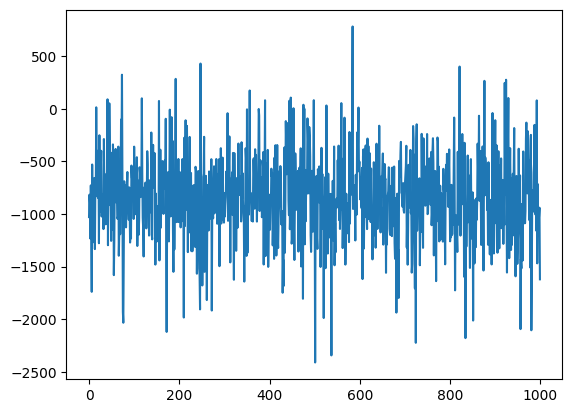

In [492]:
plt.plot(fitness)

In [498]:
pd.DataFrame(dd)

,buy_tries,sell_tries,fitness
0,"[2, 11, 15, 63, 69, 72, 76, 82, 88]","[6, 13, 47, 64, 71, 75, 77, 85, 89]",14.48206
1,"[15, 18, 37, 65, 70, 88, 120, 135, 157]","[16, 33, 38, 68, 84, 114, 121, 141, 158]",90.52714
2,"[10, 15, 17, 28, 43, 104, 120, 128, 140]","[12, 16, 26, 37, 78, 106, 124, 130, 154]",324.33072
3,"[15, 34, 37, 43, 98, 123, 143, 149, 152]","[20, 36, 42, 49, 100, 129, 148, 150, 161]",430.45130
4,"[15, 17, 27, 43, 62, 104, 106, 140, 152]","[16, 24, 39, 54, 84, 105, 111, 149, 157]",782.94440


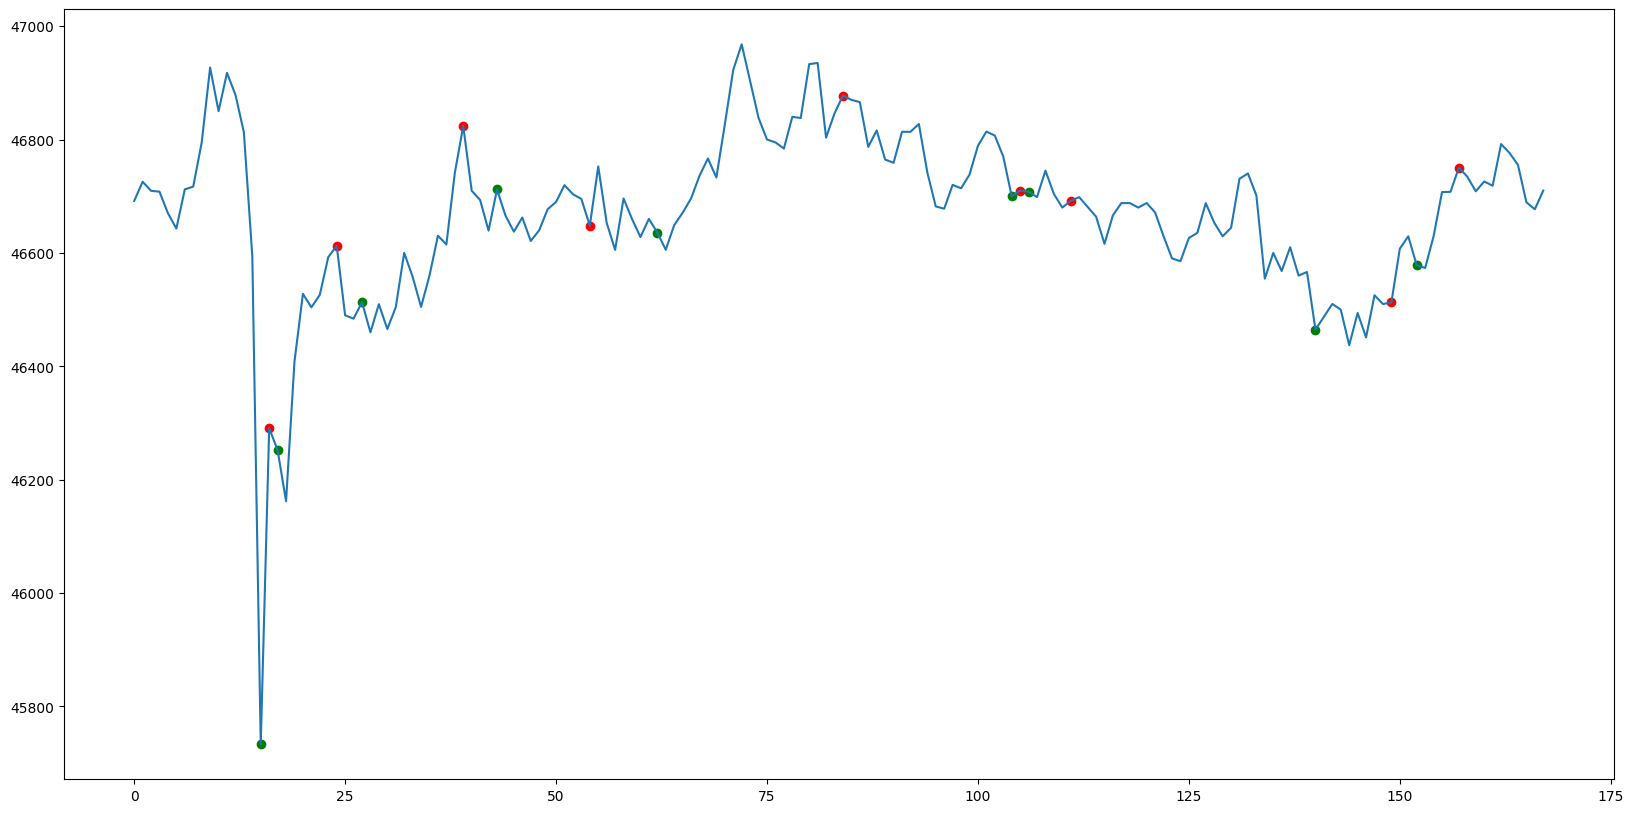

In [499]:
i = 4
plt.figure(figsize=(20,10))
plt.plot(range(len(small_period['open'])),small_period['open'])
plt.scatter(dd['buy_tries'][i], small_period['open'].loc[dd['buy_tries'][i]], color='green')
plt.scatter(dd['sell_tries'][i], small_period['open'].loc[dd['sell_tries'][i]], color='red')